In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [2]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [13]:
now = pd.Timestamp.now()
pdFilter = 'jsonPayload.method="submitNewBlock" AND "received block from builder" ' + \
           'AND jsonPayload.builderPubkey="0x8000008a03ebae7d8ab2f66659bd719a698b2e74097d1e423df85e0d58571140527c15052a36c19878018aaebe8a6fea" ' + \
           'AND timestamp>=' + '\"' + (now - pd.Timedelta('3h')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'

In [14]:
payloads = []
for e in client.list_entries(filter_=pdFilter):
    payloads.append(e.to_api_repr()['jsonPayload'])
payloads = pd.DataFrame(payloads)

In [15]:
payloads = pd.DataFrame(payloads)

In [16]:
len(payloads), payloads.keys()

(6237,
 Index(['timestampRequestStart', 'timestampAfterBidUpdate',
        'wasBidSavedInRedis', 'fastTrackValidation', 'proposerPubkey', 'method',
        'timestampBeforeSignatureCheck', 'prevTopBidValue', 'slot',
        'timestampAfterChecks1', 'topBidValue',
        'timestampBeforeAttributesCheck', 'payloadBytes', 'profilePrechecksUs',
        'profileRedisUpdateFloorUs', 'parentHash', 'headSlot', 'version',
        'profileRedisUpdateTopBidUs', 'profileRedisSavePayloadUs',
        'profileSimUs', 'builderIsHighPrio', 'level', 'newBidIsTopBid',
        'builderPubkey', 'profileTotalUs', 'value', 'reqContentType',
        'timestampEligibleAt', 'blockHash', 'timestampBeforeValidation',
        'timestampAfterDecoding', 'contentLength', 'profileDecodeUs',
        'floorBidValue', 'timestampAfterSignatureCheck', 'reqIsGzip',
        'cancellationEnabled', 'wasTopBidUpdated', 'numTx', 'msg', 'service',
        'profileRedisUs', 'isLargeRequest', 'validationDurationMs',
        'times

In [17]:
ssz = payloads[payloads['reqContentType'] == 'ssz']
json = payloads[payloads['reqContentType'] == 'json']
len(ssz), len(json)

(0, 6237)

In [18]:
bn = payloads[payloads['builderPubkey']=='0x8000008a03ebae7d8ab2f66659bd719a698b2e74097d1e423df85e0d58571140527c15052a36c19878018aaebe8a6fea']
ssz = bn[bn['reqContentType'] == 'ssz']
json = bn[bn['reqContentType'] == 'json']
len(ssz), len(json)

(0, 6237)

In [11]:
bn2 = payloads[payloads['builderPubkey']=='0xa00000a975dffbd1ef61953ac6c90b52b70eb0188eb9d030774346c9248f81e875f7e8bc56c4bbbda297a9543cfa051d']
ssz2 = bn2[bn2['reqContentType'] == 'ssz']
json2 = bn2[bn2['reqContentType'] == 'json']
len(ssz2), len(json2)

(1147, 4257)

Text(0.5, 1.0, 'time to decode payload')

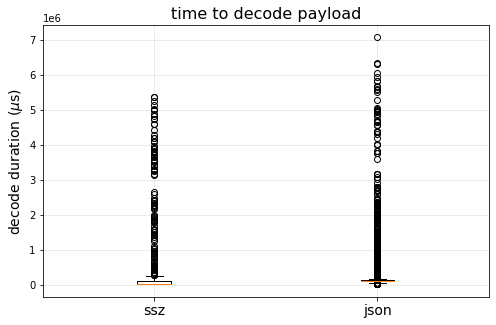

In [29]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([ssz2.profileTotalUs, json2.profileTotalUs])
ax.set_xticklabels(['ssz', 'json'], size=14)
ax.set_ylabel('decode duration ($\mu$s)', size=14)
ax.set_title('time to decode payload', size=16)

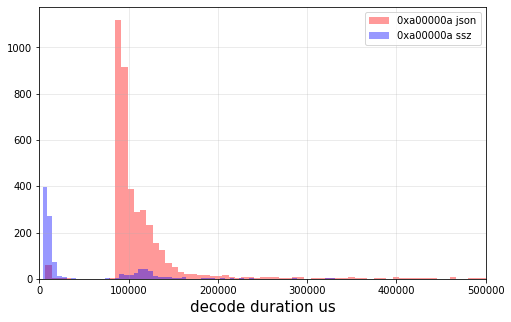

In [25]:
f, ax = plt.subplots(figsize=(8,5))
ax.hist(json2.profileTotalUs, bins=1000, color='r', alpha=0.4, label='0xa00000a json')
ax.hist(ssz2.profileTotalUs, bins=1000, color='b', alpha=0.4, label='0xa00000a ssz')
ax.set_xlim(0,500000)
ax.set_xlabel('decode duration us', size=15)
ax.legend()
plt.show()

In [30]:
print('ssz total\_duration percentiles & ', end='')
st = ''
for i in [50, 75, 90, 99]:
    st += str(int(np.percentile(ssz2.profileTotalUs, i)))
    st += " & "
print(st)
print('json total\_duration percentiles & ', end='')
st = ''
for i in [50, 75, 90, 99]:
    st += str(int(np.percentile(json2.profileTotalUs, i)))
    st += " & "
print(st)

ssz total\_duration percentiles & 11995 & 112983 & 234254 & 4595191 & 
json total\_duration percentiles & 99002 & 122810 & 193673 & 3049002 & 


Text(0.5, 1.0, 'time to decode payload')

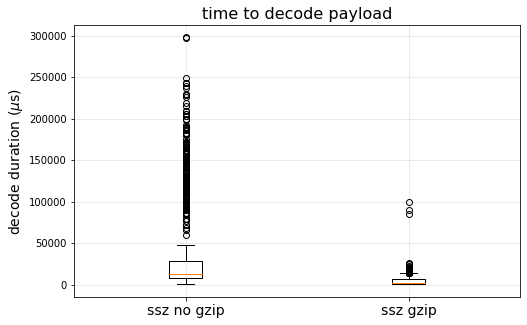

In [40]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([ssz[ssz.reqIsGzip==False].profileDecodeUs, ssz[ssz.reqIsGzip==True].profileDecodeUs])
ax.set_xticklabels(['ssz no gzip', 'ssz gzip'], size=14)
ax.set_ylabel('decode duration ($\mu$s)', size=14)
ax.set_title('time to decode payload', size=16)